In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt 
import seaborn as sns 
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from PIL import Image, ImageFilter
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import torch.optim.lr_scheduler as lr_scheduler
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from albumentations.core.transforms_interface import ImageOnlyTransform

In [ ]:
# 잘못된 레이블 바로잡기 코드 - 귀찮으니 간단하게 노가다 살짝
# train['target'][train['ID'] == '45f0d2dfc7e47c03.jpg'] = 7
# train['target'][train['ID'] == 'aec62dced7af97cd.jpg'] = 14
# train['target'][train['ID'] == '8646f2c3280a4f49.jpg'] = 3
# train['target'][train['ID'] == '1ec14a14bbe633db.jpg'] = 7
# train['target'][train['ID'] == '7100c5c67aecadc5.jpg'] = 7
# train['target'][train['ID'] == 'c5182ab809478f12.jpg'] = 14
# train['target'][train['ID'] == '38d1796b6ad99ddd.jpg'] = 10
# train['target'][train['ID'] == '0583254a73b48ece.jpg'] = 10

In [4]:
import pandas as pd

train=pd.read_csv('data/train.csv')

# 수정할 레이블 정보를 딕셔너리로 저장
label_corrections = {
    '45f0d2dfc7e47c03.jpg': 7,
    'aec62dced7af97cd.jpg': 14,
    '8646f2c3280a4f49.jpg': 3,
    '1ec14a14bbe633db.jpg': 7,
    '7100c5c67aecadc5.jpg': 7,
    'c5182ab809478f12.jpg': 14,
    '38d1796b6ad99ddd.jpg': 10,
    '0583254a73b48ece.jpg': 10
}

# 'ID' 열을 기준으로 레이블 수정
train['target'] = train.apply(lambda row: label_corrections.get(row['ID'], row['target']), axis=1)


In [ ]:
import os
from PIL import Image

def get_image_sizes(folder_path):
    image_sizes = {}
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder_path, filename)
            with Image.open(image_path) as img:
                image_sizes[filename] = img.size  # (width, height)
    
    return image_sizes

folder_path = 'data/train/'
image_sizes = get_image_sizes(folder_path)

for filename, size in image_sizes.items():
    print(f"{filename}: {size[0]}x{size[1]} pixels")


In [6]:
import os
from PIL import Image
import pandas as pd

# CSV 파일 경로와 이미지 폴더 경로
csv_file_path = 'data/train.csv'
folder_path = 'data/train/'

# 이미지 사이즈를 저장할 리스트
image_sizes = []

# 각 이미지의 사이즈 계산
for filename in train['ID']:
    image_path = os.path.join(folder_path, filename)
    if os.path.exists(image_path):
        with Image.open(image_path) as img:
            size = f"{img.size[0]}*{img.size[1]}"
            image_sizes.append(size)
    else:
        image_sizes.append(None)  # 이미지 파일이 없으면 None으로 처리

# 새로운 컬럼 추가
train['image_size'] = image_sizes

In [7]:
train.head()

,ID,target,image_size
0,002f99746285dfdd.jpg,16,443*591
1,008ccd231e1fea5d.jpg,10,443*591
2,008f5911bfda7695.jpg,10,443*591
3,009235e4c9c07af5.jpg,4,443*591
4,00b2f44967580c74.jpg,16,443*591


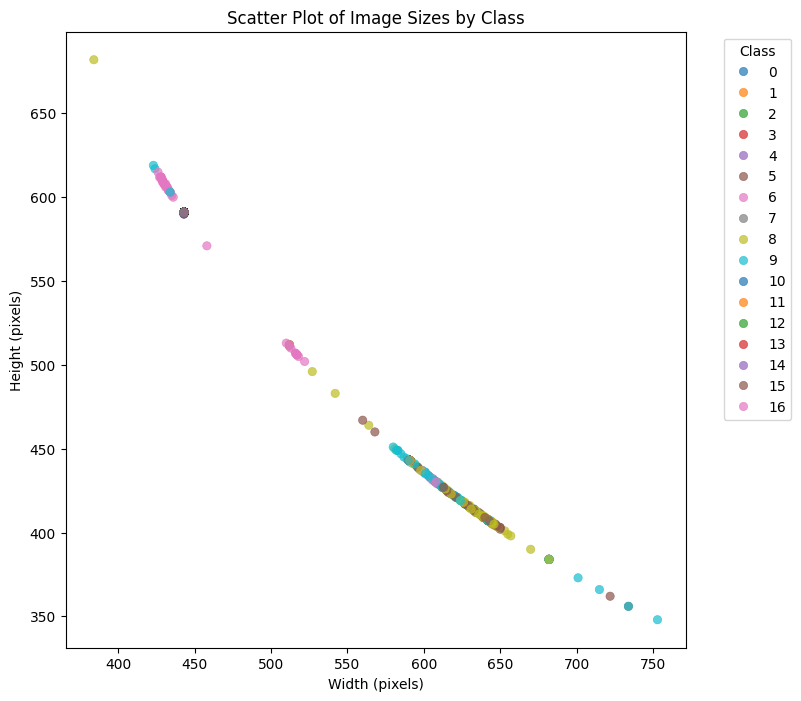

In [9]:
# 이미지 사이즈를 너비와 높이로 분리
train[['width', 'height']] = train['image_size'].str.split('*', expand=True)
train['width'] = train['width'].astype(int)
train['height'] = train['height'].astype(int)

# scatter plot 그리기
plt.figure(figsize=(8, 8))
scatter_plot = sns.scatterplot(data=train, x='width', y='height', hue='target', palette='tab10', alpha=0.7, edgecolor=None)

# 그래프 꾸미기
plt.title('Scatter Plot of Image Sizes by Class')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

# 그래프 출력
plt.show()

In [7]:
def get_average_rgb(image_path):
    with Image.open(image_path) as img:
        img = img.convert('RGB')
        np_img = np.array(img)
        w, h, d = np_img.shape
        return np_img.reshape((w * h, d)).mean(axis=0)


folder_path = 'data/train/'

# 이미지 RGB 값을 저장할 리스트
average_rgbs = []

# 각 이미지의 RGB 값 계산
for filename in train['ID']:
    image_path = os.path.join(folder_path, filename)
    if os.path.exists(image_path):
        avg_rgb = get_average_rgb(image_path)
        average_rgbs.append(avg_rgb)
    else:
        average_rgbs.append([None, None, None])  # 이미지 파일이 없으면 None으로 처리

# 새로운 컬럼 추가
train[['avg_r', 'avg_g', 'avg_b']] = pd.DataFrame(average_rgbs, index=train.index)




In [11]:
train.head()

,ID,target,image_size,width,height,avg_r,avg_g,avg_b
0,002f99746285dfdd.jpg,16,443*591,443,591,112.004274,113.172398,111.967966
1,008ccd231e1fea5d.jpg,10,443*591,443,591,156.943521,158.016737,160.313212
2,008f5911bfda7695.jpg,10,443*591,443,591,159.396417,161.210944,162.958459
3,009235e4c9c07af5.jpg,4,443*591,443,591,145.003571,145.747656,146.071093
4,00b2f44967580c74.jpg,16,443*591,443,591,94.514470,103.902209,107.107928


In [12]:
train['image_size']=train['width']*train['height']
train.head()

,ID,target,image_size,width,height,avg_r,avg_g,avg_b
0,002f99746285dfdd.jpg,16,261813,443,591,112.004274,113.172398,111.967966
1,008ccd231e1fea5d.jpg,10,261813,443,591,156.943521,158.016737,160.313212
2,008f5911bfda7695.jpg,10,261813,443,591,159.396417,161.210944,162.958459
3,009235e4c9c07af5.jpg,4,261813,443,591,145.003571,145.747656,146.071093
4,00b2f44967580c74.jpg,16,261813,443,591,94.514470,103.902209,107.107928


In [13]:
meta_df=pd.read_csv('data/meta.csv')
meta_df.head()

,target,class_name
0,0,account_number
1,1,application_for_payment_of_pregnancy_medical_e...
2,2,car_dashboard
3,3,confirmation_of_admission_and_discharge
4,4,diagnosis


In [14]:
meta_df['class_name'].unique()

array(['account_number',
       'application_for_payment_of_pregnancy_medical_expenses',
       'car_dashboard', 'confirmation_of_admission_and_discharge',
       'diagnosis', 'driver_lisence', 'medical_bill_receipts',
       'medical_outpatient_certificate', 'national_id_card', 'passport',
       'payment_confirmation', 'pharmaceutical_receipt', 'prescription',
       'resume', 'statement_of_opinion',
       'vehicle_registration_certificate', 'vehicle_registration_plate'],
      dtype=object)

In [15]:
train = pd.merge(train, meta_df, on='target', how='left')
train['origin_index'] = train.index
train.head()

,ID,target,image_size,width,height,avg_r,avg_g,avg_b,class_name,origin_index
0,002f99746285dfdd.jpg,16,261813,443,591,112.004274,113.172398,111.967966,vehicle_registration_plate,0
1,008ccd231e1fea5d.jpg,10,261813,443,591,156.943521,158.016737,160.313212,payment_confirmation,1
2,008f5911bfda7695.jpg,10,261813,443,591,159.396417,161.210944,162.958459,payment_confirmation,2
3,009235e4c9c07af5.jpg,4,261813,443,591,145.003571,145.747656,146.071093,diagnosis,3
4,00b2f44967580c74.jpg,16,261813,443,591,94.514470,103.902209,107.107928,vehicle_registration_plate,4


In [14]:
# train_final.to_csv('data/train_final.csv', index=False)

1. 이상치 제거 아직 안됨
2. 라벨링 틀린 것 수정 안됨

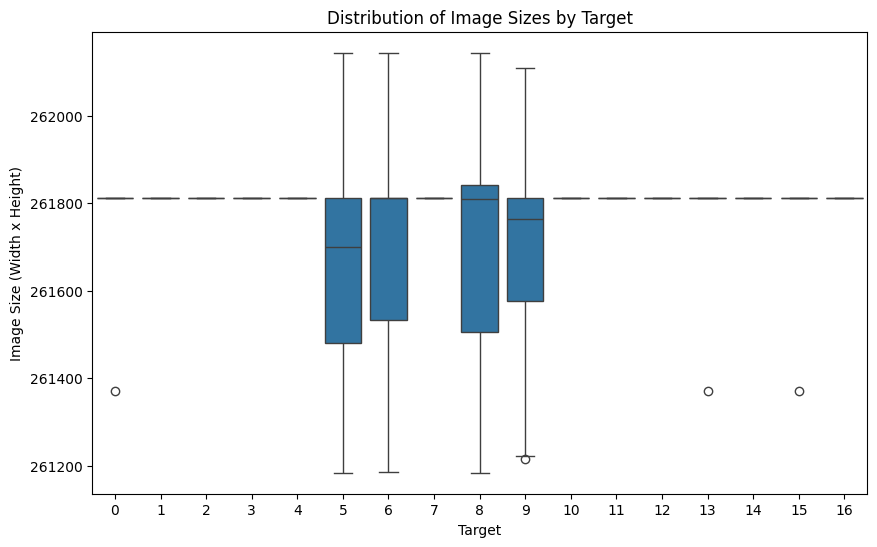

In [16]:
# image_size 이상치 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='image_size', data=train)
plt.title('Distribution of Image Sizes by Target')
plt.xlabel('Target')
plt.ylabel('Image Size (Width x Height)')
plt.show()

In [17]:
# boxplot을 이용한 이상치 추출 함수
def get_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# 각 target별로 이상치 추출
outliers_img_size = train.groupby('target').apply(lambda group: get_outliers(group, 'image_size')).reset_index(drop=True)

# 이상치 데이터프레임 출력
outliers_img_size

,ID,target,image_size,width,height,avg_r,avg_g,avg_b,class_name,origin_index
0,df1caa3d9f344b5a.jpg,0,261370,443,590,182.417416,180.088828,181.404178,account_number,1393
1,21b62e20ee3bdea6.jpg,9,261215,587,445,126.145179,122.136455,115.607293,passport,207
2,3c99358b35b7e8fa.jpg,13,261370,443,590,166.622524,166.440173,164.872415,resume,369
3,4a48e1d9202ed3e1.jpg,15,261370,443,590,173.771072,172.660669,173.136714,vehicle_registration_certificate,455


In [18]:
# outliers_img_size.to_csv('data/outliers_img_size.csv')

In [ ]:
# 이상치 이미지를 train 폴더에서 확인
# image_folder_path = 'data/train/'
# for idx, row in outliers_img_size.iterrows():
#     image_path = os.path.join(image_folder_path, row['ID'])
#     if os.path.exists(image_path):
#         with Image.open(image_path) as img:
#             img.show()  # 각 이미지를 표시
#     else:
#         print(f"Image {row['ID']} not found in folder.")

이미지 사이즈 이상치 : 계좌번호, 여권, 이력서, 자동차 등록증 

-> 라벨링은 맞음

-> 해당 이미지 ID 제거 필요!

이상치 제거 

In [19]:
# 이미지 사이즈 이상치가 없는 train_final 
# outliers_ids = outliers_img_size['ID'].tolist()
# train_df = train_df[~train_df['ID'].isin(outliers_ids)]
# train_df.shape

(1566, 10)

r,g,b 평균 이상치 

In [22]:
# 각 target별로 avg_r 이상치 추출
outliers_df_r = train.groupby('target').apply(lambda group: get_outliers(group, 'avg_r')).reset_index(drop=True)

# 이상치 데이터프레임 출력
# outliers_df_r.to_csv('data/outliers_avg_r.csv',index=False)

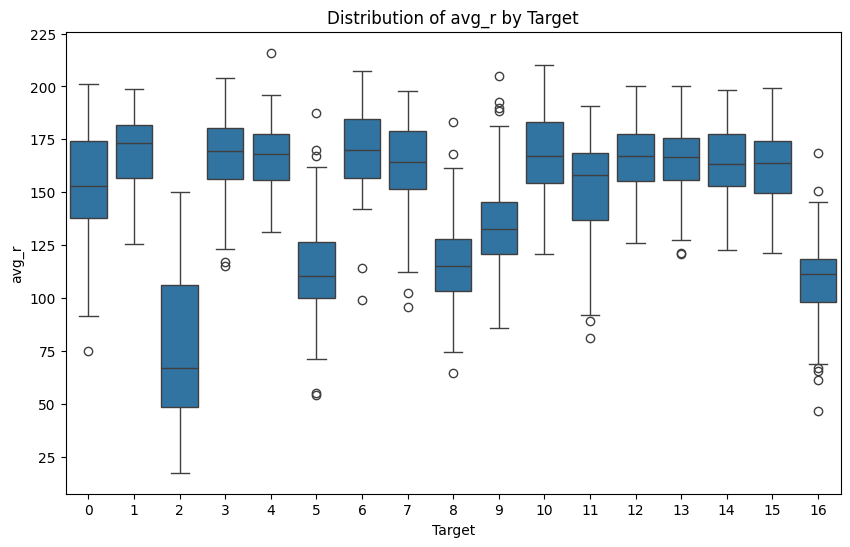

In [20]:
# avg_r 이상치 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='avg_r', data=train)
plt.title('Distribution of avg_r by Target')
plt.xlabel('Target')
plt.ylabel('avg_r')
plt.show()

In [21]:
# 이상치 이미지를 train 폴더에서 확인
# image_folder_path = 'data/train/'
# for idx, row in outliers_df_r.iterrows():
#     image_path = os.path.join(image_folder_path, row['ID'])
#     if os.path.exists(image_path):
#         with Image.open(image_path) as img:
#             img.show()  # 각 이미지를 표시
#     else:
#         print(f"Image {row['ID']} not found in folder.")

In [23]:
# 각 target별로 이상치 추출
outliers_df_b = train.groupby('target').apply(lambda group: get_outliers(group, 'avg_b')).reset_index(drop=True)

# 이상치 데이터프레임 출력
outliers_df_b.to_csv('data/outliers_avg_b.csv',index=False)


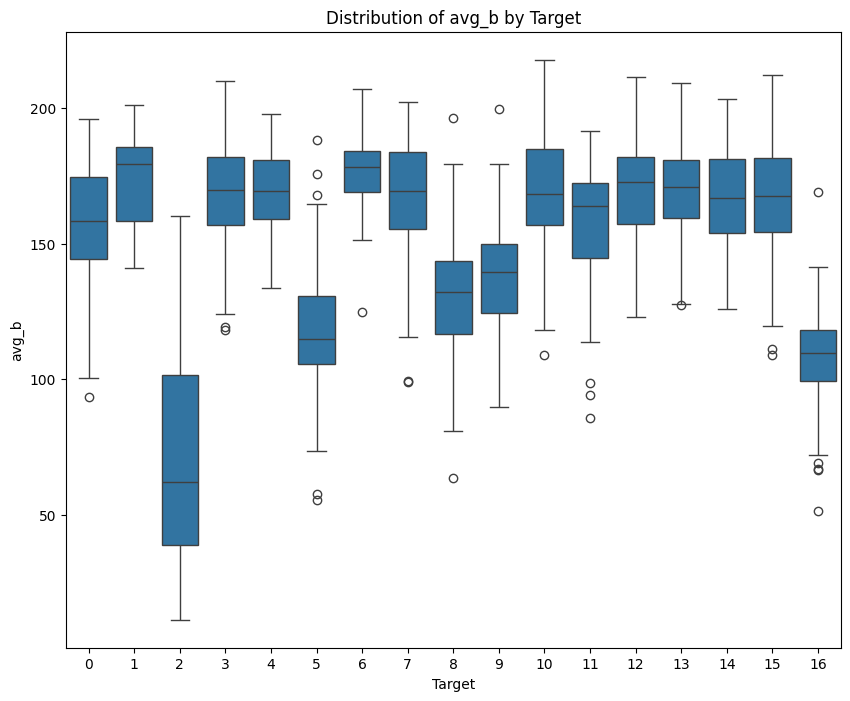

In [24]:
#  이상치 시각화
plt.figure(figsize=(10, 8))
sns.boxplot(x='target', y='avg_b', data=train)
plt.title('Distribution of avg_b by Target')
plt.xlabel('Target')
plt.ylabel('avg_b')
plt.show()

In [ ]:
# 이상치 이미지를 train 폴더에서 확인
# image_folder_path = 'data/train/'
# for idx, row in outliers_df_b.iterrows():
#     image_path = os.path.join(image_folder_path, row['ID'])
#     if os.path.exists(image_path):
#         with Image.open(image_path) as img:
#             img.show()  # 각 이미지를 표시
#     else:
#         print(f"Image {row['ID']} not found in folder.")

In [25]:
# 각 target별로 이상치 추출
outliers_df_g = train.groupby('target').apply(lambda group: get_outliers(group, 'avg_g')).reset_index(drop=True)

# 이상치 데이터프레임 출력
outliers_df_g.to_csv('data/outliers_avg_g.csv',index=False)

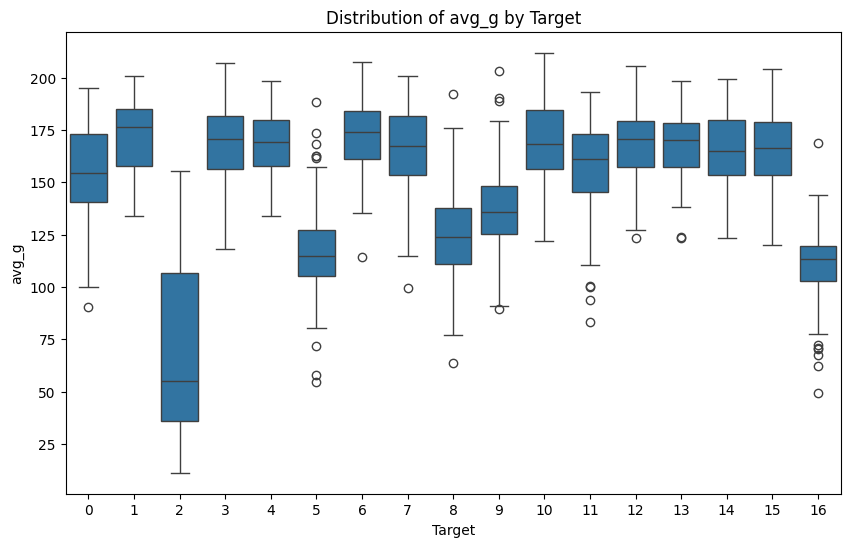

In [26]:
# avg_g 이상치 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='avg_g', data=train)
plt.title('Distribution of avg_g by Target')
plt.xlabel('Target')
plt.ylabel('avg_g')
plt.show()


In [27]:
# 이상치 이미지를 train 폴더에서 확인
# image_folder_path = 'data/train/'
# for idx, row in outliers_df_g.iterrows():
#     image_path = os.path.join(image_folder_path, row['ID'])
#     if os.path.exists(image_path):
#         with Image.open(image_path) as img:
#             img.show()  # 각 이미지를 표시
#     else:
#         print(f"Image {row['ID']} not found in folder.")

In [32]:
outliers_img_size.shape

(4, 10)

In [28]:
outliers_df_r.shape

(30, 10)

In [29]:
outliers_df_b.shape

(26, 10)

In [30]:
outliers_df_g.shape

(32, 10)

In [33]:
# 'origin_index' 값이 같은 행 추출
common_indices = outliers_df_g['origin_index'].isin(outliers_df_r['origin_index']) & outliers_df_g['origin_index'].isin(outliers_df_b['origin_index'])
result_df = outliers_df_g[['origin_index']][common_indices]  # df1에서 'origin_index' 컬럼만 선택하고 해당 행 추출

print(result_df)


    origin_index
4           1182
5           1188
7           1204
8           1211
9           1568
10            88
11           674
12           288
13           739
14           495
18            90
24          1103
25            52
27           704
31          1539


In [34]:
outliers_rgb_list=result_df['origin_index']
outliers_avg_rgb=train[train['origin_index'].isin(outliers_rgb_list)]
outliers_avg_rgb

,ID,target,image_size,width,height,avg_r,avg_g,avg_b,class_name,origin_index
52,0705443203af2672.jpg,16,261813,591,443,65.610837,67.722852,66.306883,vehicle_registration_plate,52
88,0db0f87709c7c403.jpg,6,261813,443,591,98.853682,114.163540,124.631264,medical_bill_receipts,88
90,0e1eb96c88179e6e.jpg,11,261813,443,591,80.911803,83.405881,85.586648,pharmaceutical_receipt,90
288,30363ae8afb9f685.jpg,8,262144,512,512,64.674965,63.878471,63.437923,national_id_card,288
495,4f251e4f50e1b033.jpg,9,261767,583,449,205.076939,203.049384,199.585070,passport,495
674,6833fc9562046889.jpg,7,261813,443,591,95.964070,99.677228,98.953784,medical_outpatient_certificate,674
704,6d41878ae3c7e40b.jpg,16,261813,443,591,168.408906,168.888264,168.950480,vehicle_registration_plate,704
739,73b17549c8ab8a99.jpg,8,261813,591,443,183.176294,192.410048,196.459003,national_id_card,739
1103,b0ab48967aaabefe.jpg,13,261813,443,591,120.993537,123.623223,127.207599,resume,1103
1182,bcfa1ce6259aaedd.jpg,5,261888,682,384,54.900889,54.782270,55.321989,driver_lisence,1182


In [35]:
outliers_avg_rgb.to_csv('/data/outliers_avg_rgb.csv', index=False)

In [8]:
test=pd.read_csv('data/sample_submission.csv')
test.head()

,ID,target
0,0008fdb22ddce0ce.jpg,0
1,00091bffdffd83de.jpg,0
2,00396fbc1f6cc21d.jpg,0
3,00471f8038d9c4b6.jpg,0
4,00901f504008d884.jpg,0


In [9]:
test['origin_index']=test.index
test.head()

,ID,target,origin_index
0,0008fdb22ddce0ce.jpg,0,0
1,00091bffdffd83de.jpg,0,1
2,00396fbc1f6cc21d.jpg,0,2
3,00471f8038d9c4b6.jpg,0,3
4,00901f504008d884.jpg,0,4


In [10]:
# CSV 파일 경로와 이미지 폴더 경로
csv_file_path = 'data/sample_submission.csv'
folder_path = 'data/test/'

# 이미지 사이즈를 저장할 리스트
image_sizes = []

# 각 이미지의 사이즈 계산
for filename in test['ID']:
    image_path = os.path.join(folder_path, filename)
    if os.path.exists(image_path):
        with Image.open(image_path) as img:
            size = f"{img.size[0]}*{img.size[1]}"
            image_sizes.append(size)
    else:
        image_sizes.append(None)  # 이미지 파일이 없으면 None으로 처리

# 새로운 컬럼 추가
test['image_size'] = image_sizes

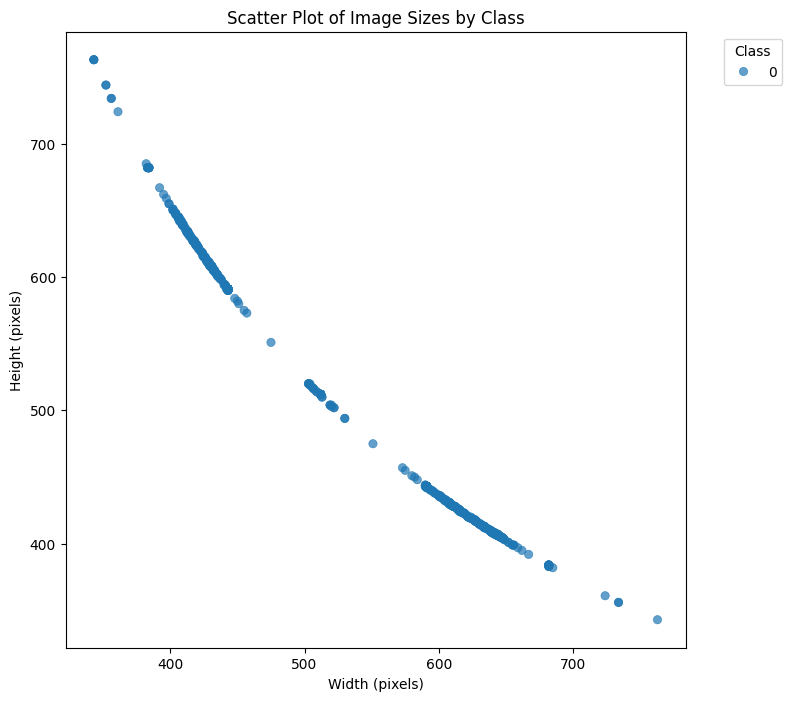

In [11]:
# 이미지 사이즈를 너비와 높이로 분리
test[['width', 'height']] = test['image_size'].str.split('*', expand=True)
test['width'] = test['width'].astype(int)
test['height'] = test['height'].astype(int)

# scatter plot 그리기
plt.figure(figsize=(8, 8))
scatter_plot = sns.scatterplot(data=test, x='width', y='height', hue='target', palette='tab10', alpha=0.7, edgecolor=None)

# 그래프 꾸미기
plt.title('Scatter Plot of Image Sizes by Class')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

# 그래프 출력
plt.show()

In [12]:
def get_average_rgb(image_path):
    with Image.open(image_path) as img:
        img = img.convert('RGB')
        np_img = np.array(img)
        w, h, d = np_img.shape
        return np_img.reshape((w * h, d)).mean(axis=0)


folder_path = 'data/test/'

# 이미지 RGB 값을 저장할 리스트
average_rgbs = []

# 각 이미지의 RGB 값 계산
for filename in test['ID']:
    image_path = os.path.join(folder_path, filename)
    if os.path.exists(image_path):
        avg_rgb = get_average_rgb(image_path)
        average_rgbs.append(avg_rgb)
    else:
        average_rgbs.append([None, None, None])  # 이미지 파일이 없으면 None으로 처리

# 새로운 컬럼 추가
test[['avg_r', 'avg_g', 'avg_b']] = pd.DataFrame(average_rgbs, index=test.index)


In [13]:
test.head()

,ID,target,origin_index,image_size,width,height,avg_r,avg_g,avg_b
0,0008fdb22ddce0ce.jpg,0,0,443*591,443,591,106.337905,102.642623,107.840543
1,00091bffdffd83de.jpg,0,1,591*443,591,443,189.749252,190.235420,189.443943
2,00396fbc1f6cc21d.jpg,0,2,408*642,408,642,117.557625,124.719714,130.059843
3,00471f8038d9c4b6.jpg,0,3,591*443,591,443,211.383338,212.180350,211.408551
4,00901f504008d884.jpg,0,4,443*591,443,591,93.273550,87.968348,89.147380


In [14]:
test['image_size']=test['width']*test['height']
test.head()

,ID,target,origin_index,image_size,width,height,avg_r,avg_g,avg_b
0,0008fdb22ddce0ce.jpg,0,0,261813,443,591,106.337905,102.642623,107.840543
1,00091bffdffd83de.jpg,0,1,261813,591,443,189.749252,190.235420,189.443943
2,00396fbc1f6cc21d.jpg,0,2,261936,408,642,117.557625,124.719714,130.059843
3,00471f8038d9c4b6.jpg,0,3,261813,591,443,211.383338,212.180350,211.408551
4,00901f504008d884.jpg,0,4,261813,443,591,93.273550,87.968348,89.147380


In [15]:
# column 자리 옮기기 
def move_column(df,column_name,position):
    cols=df.columns.tolist()
    cols.insert(position,cols.pop(cols.index(column_name)))
    return df[cols]


In [17]:
# train=move_column(train,'origin_index',0)
# train.head()

In [18]:
test=move_column(test,'origin_index',0)
test.head()

,origin_index,ID,target,image_size,width,height,avg_r,avg_g,avg_b
0,0,0008fdb22ddce0ce.jpg,0,261813,443,591,106.337905,102.642623,107.840543
1,1,00091bffdffd83de.jpg,0,261813,591,443,189.749252,190.235420,189.443943
2,2,00396fbc1f6cc21d.jpg,0,261936,408,642,117.557625,124.719714,130.059843
3,3,00471f8038d9c4b6.jpg,0,261813,591,443,211.383338,212.180350,211.408551
4,4,00901f504008d884.jpg,0,261813,443,591,93.273550,87.968348,89.147380


In [47]:
# train.to_csv('train_final.csv',index=False)
# test.to_csv('test_final.csv',index=False)

In [19]:
# boxplot을 이용한 이상치 추출 함수
def get_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# 각 target별로 이상치 추출
outliers_img_size_test = test.groupby('target').apply(lambda group: get_outliers(group, 'image_size')).reset_index(drop=True)

# 이상치 데이터프레임 출력
outliers_img_size_test

,origin_index,ID,target,image_size,width,height,avg_r,avg_g,avg_b
0,2,00396fbc1f6cc21d.jpg,0,261936,408,642,117.557625,124.719714,130.059843
1,7,00bbdcfbbdb3e131.jpg,0,261630,646,405,151.816565,151.043321,151.337507
2,10,00dcea90f63ad630.jpg,0,261936,408,642,144.296782,146.557075,149.293224
3,13,0111a6728e9f8a73.jpg,0,261429,633,413,153.045209,151.704558,149.163471
4,17,016240faa186d24d.jpg,0,261744,656,399,129.836401,129.012982,128.497303
...,...,...,...,...,...,...,...,...,...
523,3117,fdcd392ca7d3ba10.jpg,0,261429,413,633,167.139476,170.003270,174.975129
524,3122,fe86b7318956bf3f.jpg,0,261360,605,432,127.368966,136.425272,143.596289
525,3124,fecc824e850e1f41.jpg,0,261370,443,590,171.747748,173.958534,176.856426
526,3128,ff2f82db799bf247.jpg,0,262144,512,512,183.334473,183.361897,183.979637


In [20]:
# outliers_img_size_test.to_csv('data/outliers_img_size_test.csv', index=False)

In [ ]:
outliers_avg_r_test = test.groupby('target').apply(lambda group: get_outliers(group,'avg_r')).reset_index(drop=True)
outliers_avg_r_test # 66

In [ ]:
outliers_avg_g_test = test.groupby('target').apply(lambda group: get_outliers(group,'avg_g')).reset_index(drop=True)
outliers_avg_g_test # 74

In [ ]:
outliers_avg_b_test = test.groupby('target').apply(lambda group: get_outliers(group,'avg_b')).reset_index(drop=True)
outliers_avg_b_test # 78


In [24]:
import pandas as pd


def outliers_to_csv_test(df: pd.DataFrame, columns: list, output_folder: str = "data"):
    
    for col in columns:
        # Calculate quantiles (you'll need to define how you determine outliers here)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        # Create a meaningful filename that includes the column name
        filename = f"{output_folder}/outliers_{col}_test.csv"

        # Save outliers to a CSV file
        if not outliers.empty:  # Check if any outliers were found
            outliers.to_csv(filename, index=False)
            print(f"Outliers for '{col}' saved to: {filename}")
        else:
            print(f"No outliers found for '{col}'.")
    

In [48]:
# col=['image_size','avg_r','avg_b','avg_g']
# outliers_to_csv_test(test,col)

In [ ]:
# avg_g 이상치 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='avg_r', data=test)
plt.title('Distribution of avg_r by Target')
plt.xlabel('Target')
plt.ylabel('avg_r')
plt.show()

In [ ]:
# avg_g 이상치 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='avg_g', data=test)
plt.title('Distribution of avg_g by Target')
plt.xlabel('Target')
plt.ylabel('avg_g')
plt.show()

In [ ]:
# avg_g 이상치 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='avg_b', data=test)
plt.title('Distribution of avg_b by Target')
plt.xlabel('Target')
plt.ylabel('avg_b')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


def visualize_outliers(df: pd.DataFrame, column: str, target_column: str = 'target', show_points=True):

    plt.figure(figsize=(10, 6))

    # Create the boxplot
    sns.boxplot(x=target_column, y=column, data=df, showmeans=True)  # Show means as well
    plt.xlabel(target_column.capitalize())  # Capitalize the target label
    plt.title(f"Distribution of '{column}' by {target_column.capitalize()}")  # Improved title clarity
    plt.ylabel(column.capitalize())  # Capitalize the column label

    # Add individual points if show_points is True
    if show_points:
        # Calculate quantiles for outlier detection
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        # Overlay scatter plot of outliers
        sns.stripplot(x=target_column, y=column, data=outliers, color='red', jitter=True, alpha=0.5)

    plt.show()



In [ ]:
# 'origin_index' 값이 같은 행 추출
common_indices = outliers_avg_g_test['origin_index'].isin(outliers_avg_b_test['origin_index']) & outliers_avg_r_test['origin_index'].isin(outliers_avg_g_test['origin_index'])
result_df = outliers_avg_g_test[['origin_index']][common_indices]  # df에서 'origin_index' 컬럼만 선택하고 해당 행 추출
outliers_rgb_list=result_df['origin_index']
outliers_avg_rgb=test[test['origin_index'].isin(outliers_rgb_list)].reset_index(drop=True)
outliers_avg_rgb

In [30]:
outliers_avg_rgb_test=outliers_avg_rgb
outliers_avg_rgb_test.to_csv('data/outliers_avg_rgb_test.csv', index=False)

In [ ]:
def visualize_dataset(dataset, set_number=1, num_images=10, is_train=True):
    total_images = len(dataset)
    start_index = (set_number - 1) * num_images
    end_index = min(start_index + num_images, total_images)

    # 이미지와 라벨 가져오기
    images = []
    labels = []
    for i in range(start_index, end_index):
        img, label = dataset[i]
        images.append(img)
        labels.append(label)

    # 그리드 생성을 위한 figure 설정
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i, (img, label) in enumerate(zip(images, labels)):
        # 이미지 표시 (정규화 해제 없이)
        img_np = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img_np)
        axes[i].axis('off')
        
        actual_index = start_index + i
        if is_train:
            # 라벨 표시 (훈련 데이터인 경우)
            class_name = class_mapping.get(label, f"알 수 없는 클래스 {label}")
            axes[i].set_title(f"{class_name}\n(인덱스: {actual_index})", fontsize=8)
        else:
            axes[i].set_title(f"인덱스: {actual_index}")
    
    # 남은 축 제거
    for i in range(len(images), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()